## The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Philipp Habicht

**Student ID:**     1372069

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Mapping between world and image coordinates
Note: Writing code for this question is optional. However, if you do not include code here you *must* show your computation steps in your written report.

In [1]:
#importing essential libaries
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

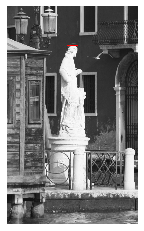

In [39]:
rootpath='./COMP90086_asst1_2022_images'
pic = cv2.imread(os.path.join(rootpath, "Asst1_1_image.png"))
imshow(pic)

In [40]:
#camera 
cam_distance = 56.34 #meters
cam_height = 1.6 #meters

#sensor
sen_height = 16.32 #milimeters
sen_wide = 9.77 #milimeters
focal_length = 194 #milimeters

Applying the following equation gives the heigt of the whole image

In [41]:
image_height = sen_height / focal_length * cam_distance
print(f'The full image has a size of {np.round(image_height,2)} meters in the real world')

The full image has a size of 4.74 meters in the real world


To calculate the exact size of the statue, I use the two red lines. The idea is to find out the exact rows of pixels of the red lines so that I have a difference of pixels where the sculpture is located. 

For this I look at the channels of the image. The red lines should have an RGB value of 255 and the blue and green lines should be 0. 

In [42]:
pic.shape

(1500, 898, 3)

In [43]:
blue_pic = pic[:,:,0] #show blue channel
green_pic = pic[:,:,1] # show green channel
red_pic = pic[:,:,2] # show red channel

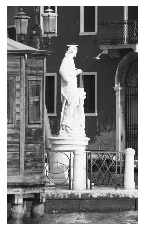

In [44]:
imshow(red_pic)

In [53]:
rows = np.where((red_pic == 255) & (green_pic == 0) & (blue_pic == 0))[0]
unique_rows = np.unique(rows)
unique_rows

array([ 270,  271, 1258, 1259])

In [54]:
unique_rows[2] - unique_rows[1]

987

I figured out that the sculpture is between the pixels rows 271 and 1258, so the statue takes 987 rows of space of the image. Now I calculate how many milimeters has 1 pixel and scale it up with our 987 pixels.

In [56]:
print(f'1 pixel is {sen_height / pic.shape[0]} milimeters')

1 pixel is 0.01088 milimeters


In [58]:
statue_projection = 987 * 0.01088
statue_projection

10.738560000000001

This is the size in milimeters of only the statue that is projected to the back of the box. I put this result into the equation used above to receive the height of the statue in real life.

In [60]:
statue_height = statue_projection / focal_length * cam_distance
print(f'The statue is {np.round(statue_height, 2)} meters high in real life')

The statue is 3.12 meters high in real life


### 2. Thinking with filters

Algorithm to count the number of intersections and dead ends in randomly-generated mazes

how can I work out a filter that detects sharpness and corners
. two different filters 
. not iterate abouve the pixels (no for loop) - use numpy
. output you want out 
. apply filter to particular shape
. sharp in filter 
. shape of intersection 
. 

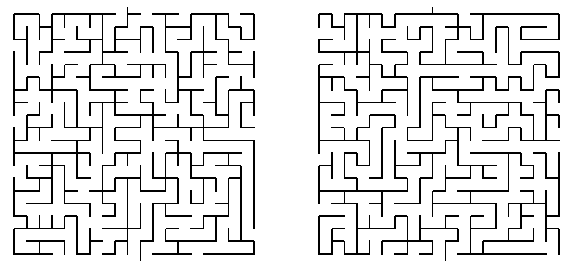

In [125]:
maze1 = cv2.imread(os.path.join("Asst1_2_maze1.png"), cv2.IMREAD_GRAYSCALE)
maze2 = cv2.imread(os.path.join("Asst1_2_maze2.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(maze1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(maze2, cmap='gray')
plt.axis('off')

plt.show()

In [4]:
print(f'The shape of Maze1 is: {maze1.shape}')
print(f'The shape of Maze2 is: {maze2.shape}')

The shape of Maze1 is: (322, 322)
The shape of Maze2 is: (322, 322)


In [53]:
#Dead ends kernel
dead_ends_down = np.ones((5,5))
dead_ends_down[2:5,2:4] = -1
dead_ends_right = np.rot90(dead_ends_down)
dead_ends_up = np.rot90(dead_ends_right)
dead_ends_left = np.rot90(dead_ends_up)

In [54]:
dead_end_kernels = [dead_ends_left, dead_ends_right, dead_ends_down, dead_ends_up]

In [144]:
#intersections
left_int = np.ones((5,5))
left_int[0:5,2:4] = -1
left_int[1:3,0:2] = -1
down_int = np.rot90(left_int)
right_int = np.rot90(down_int)
up_int = np.rot90(right_int)

#cross intersections
cross_kernel = np.ones((5,5))
cross_kernel[0:5,2:4] = -1
cross_kernel[1:3,:] = -1

In [145]:
intersection_kernels = [left_int, down_int, right_int, up_int]

In [57]:
def visualize_kernel(kernel): 

    plt.figure(figsize=(10,10))
    kernel_size = len(kernel)
    
    for i in range(kernel_size):
        plt.subplot(1, kernel_size, i+1)
        plt.imshow(kernel[i],cmap='gray')
        

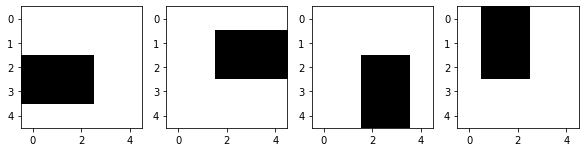

In [11]:
#visualize dead end kernel
visualize_kernel(dead_end_kernels)

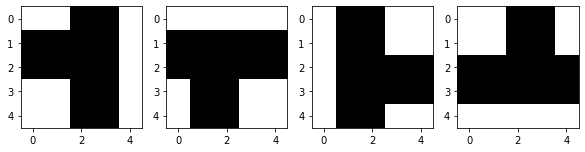

In [146]:
#visualize intersection kernel
visualize_kernel(intersection_kernels)

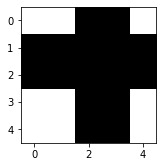

In [159]:
#visualize cross kernel
plt.figure(figsize=(2.5,2.5))
plt.imshow(cross_kernel, cmap='gray');

In [95]:
def dead_ends(maze, kernel):
    
    kernel_length = len(kernel)
    lst = []
    
    #changing RGB pixels for easier computation
    maze_copy = maze.copy()
    maze_copy[maze_copy == 0] = 1
    maze_copy[maze_copy == 255] = 0
    
    #looping through kernels
    for i in range(kernel_length):
        kernel_output = signal.convolve2d(maze_copy, kernel[i], boundary='symm', mode='same') #convolution
        lst.append(len(np.where(kernel_output == -6)[0]))
        
    return np.sum(lst)

In [155]:
def intersections(maze, kernel, cross_kernel):
    
    kernel_length = len(kernel)
    lst = []
    
    #changing RGB pixels for easier computation
    maze_copy = maze.copy()
    maze_copy[maze_copy == 0] = 1
    maze_copy[maze_copy == 255] = 0
    
    #looping through kernels
    for i in range(kernel_length):
        kernel_output = signal.convolve2d(maze_copy, kernel[i], boundary='symm', mode='same') #convolution
        lst.append(len(np.where(kernel_output == -14)[0]))
    
    #adding cross kernel to the list
    kernel_output = signal.convolve2d(maze_copy, cross_kernel, boundary='symm', mode='same') #convolution
    lst.append(len(np.where(kernel_output == -16)[0]))
        
    return np.sum(lst)

In [156]:
def result(maze, dead_end_kernels, intersection_kernels, cross_kernel):
    
    print(f"The Maze has {dead_ends(maze, dead_end_kernels)} dead ends and {intersections(maze, intersection_kernels, cross_kernel)} intersections")
    

## Maze 1

In [157]:
result(maze1, dead_end_kernels, intersection_kernels, cross_kernel)

The Maze has 98 dead ends and 87 intersections


## Maze 2

In [158]:
result(maze2, dead_end_kernels, intersection_kernels, cross_kernel)

The Maze has 74 dead ends and 71 intersections
